# Imports


## Importando as bibliotecas que serão utilizadas

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import darts  # Biblioteca para previsão de séries temporais
from darts.utils.statistics import check_seasonality, plot_acf
from sklearn.metrics import root_mean_squared_log_error
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb



custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

## Importado os Datasets

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
df_stores = pd.read_csv("stores.csv")
df_oil = pd.read_csv("oil.csv")
df_holidays = pd.read_csv("holidays_events.csv")
df_transactions = pd.read_csv("transactions.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [4]:
def summary(df):
    summ = pd.DataFrame(index = list(df))
    summ['type'] = df.dtypes
    summ['count'] = df.count()
    summ['nunique'] = df.nunique()
    summ['%unique'] = summ['nunique'] / len(df) * 100
    summ['null'] = df.isnull().sum()
    summ['%null'] = summ['null'] / len(df) * 100
    summ['min'] = df.min()
    summ['max'] = df.max()
    return summ

In [4]:
train.head(10)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


In [5]:
summary(train)


,type,count,nunique,%unique,null,%null,min,max
id,int64,3000888,3000888,100.000000,0,0.0,0,3000887
date,object,3000888,1684,0.056117,0,0.0,2013-01-01,2017-08-15
store_nbr,int64,3000888,54,0.001799,0,0.0,1,54
family,object,3000888,33,0.001100,0,0.0,AUTOMOTIVE,SEAFOOD
sales,float64,3000888,379610,12.649922,0,0.0,0.0,124717.0
onpromotion,int64,3000888,362,0.012063,0,0.0,0,741


In [6]:
test.head(10)


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
5,3000893,2017-08-16,1,BREAD/BAKERY,12
6,3000894,2017-08-16,1,CELEBRATION,0
7,3000895,2017-08-16,1,CLEANING,25
8,3000896,2017-08-16,1,DAIRY,45
9,3000897,2017-08-16,1,DELI,18


In [7]:
summary(test)


,type,count,nunique,%unique,null,%null,min,max
id,int64,28512,28512,100.000000,0,0.0,3000888,3029399
date,object,28512,16,0.056117,0,0.0,2017-08-16,2017-08-31
store_nbr,int64,28512,54,0.189394,0,0.0,1,54
family,object,28512,33,0.115741,0,0.0,AUTOMOTIVE,SEAFOOD
onpromotion,int64,28512,212,0.743547,0,0.0,0,646


In [5]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    return df

# Análise dos Dados

Primeiro irei verificar quais famílias de produtos não são vendidas em cada loja.


In [4]:
store_family_sales = train.groupby(['store_nbr', 'family'])['sales'].agg(['sum', 'count']).reset_index()

never_selling = store_family_sales[store_family_sales['sum'] == 0]

print("\nFamilias de produto que nunca venderam em cada loja:")
print("==============================================")

for store in sorted(never_selling['store_nbr'].unique()):
    store_data = never_selling[never_selling['store_nbr'] == store]
    print(f"\nLoja {store}:")
    print("-" * 50)
    for _, row in store_data.iterrows():
        print(f"{row['family']}: {row['count']} dias com vendas zero")



Familias de produto que nunca venderam em cada loja:

Loja 1:
--------------------------------------------------
BABY CARE: 1684 dias com vendas zero

Loja 9:
--------------------------------------------------
BOOKS: 1684 dias com vendas zero

Loja 10:
--------------------------------------------------
BOOKS: 1684 dias com vendas zero

Loja 11:
--------------------------------------------------
BOOKS: 1684 dias com vendas zero

Loja 12:
--------------------------------------------------
BOOKS: 1684 dias com vendas zero

Loja 13:
--------------------------------------------------
BABY CARE: 1684 dias com vendas zero
BOOKS: 1684 dias com vendas zero

Loja 14:
--------------------------------------------------
BOOKS: 1684 dias com vendas zero
LAWN AND GARDEN: 1684 dias com vendas zero

Loja 15:
--------------------------------------------------
BOOKS: 1684 dias com vendas zero

Loja 16:
--------------------------------------------------
BOOKS: 1684 dias com vendas zero
LADIESWEAR: 1684 d

In [6]:
def get_never_sold_by_store(train_df):

    store_family_sales = train_df.groupby(['store_nbr', 'family'], observed=True)['sales'].sum().reset_index()
    never_selling = store_family_sales[store_family_sales['sales'] == 0]

    never_sold_map = {}
    for store in sorted(never_selling['store_nbr'].unique()):
        store_data = never_selling[never_selling['store_nbr'] == store]
        never_sold_map[store] = store_data['family'].tolist()

    return never_sold_map

In [7]:
never_sold_output = get_never_sold_by_store(train)
print("Hashmap de lojas e famílias de produtos nunca vendidas:")
print("=======================================================")
for store, families in never_sold_output.items():
    print(f"Loja {store}: {families}")


Hashmap de lojas e famílias de produtos nunca vendidas:
Loja 1: ['BABY CARE']
Loja 9: ['BOOKS']
Loja 10: ['BOOKS']
Loja 11: ['BOOKS']
Loja 12: ['BOOKS']
Loja 13: ['BABY CARE', 'BOOKS']
Loja 14: ['BOOKS', 'LAWN AND GARDEN']
Loja 15: ['BOOKS']
Loja 16: ['BOOKS', 'LADIESWEAR']
Loja 17: ['BOOKS']
Loja 18: ['BOOKS']
Loja 19: ['BOOKS']
Loja 20: ['BOOKS']
Loja 21: ['BOOKS']
Loja 22: ['BOOKS']
Loja 23: ['BABY CARE']
Loja 25: ['LADIESWEAR']
Loja 28: ['BOOKS', 'LADIESWEAR']
Loja 29: ['BOOKS', 'LADIESWEAR']
Loja 30: ['BOOKS', 'LAWN AND GARDEN']
Loja 31: ['BOOKS']
Loja 32: ['BOOKS', 'LADIESWEAR']
Loja 33: ['BOOKS', 'LADIESWEAR']
Loja 34: ['BOOKS']
Loja 35: ['BOOKS', 'LADIESWEAR']
Loja 36: ['BOOKS']
Loja 39: ['BOOKS']
Loja 40: ['BOOKS', 'LADIESWEAR']
Loja 43: ['BOOKS', 'LADIESWEAR']
Loja 44: ['BABY CARE']
Loja 45: ['BABY CARE']
Loja 46: ['BABY CARE']
Loja 47: ['BABY CARE']
Loja 48: ['BABY CARE']
Loja 49: ['BABY CARE']
Loja 50: ['BABY CARE']
Loja 51: ['BABY CARE']
Loja 52: ['BABY CARE', 'BOOKS']
Loj

Com isso, vemos que, por exemplo, a loja 1 não vende produtos baby care. Com essa informação podemos fazer com que a previsão nessas famílias de produtos sempre estejam corretas, pois iremos igualar a zero.

In [8]:
def find_ids_of_never_sold_items(never_sold_map, items_df):
    
    matching_ids = []
    # Assegura que 'family' em items_df seja tratada como string para consistência na comparação
    items_df['family'] = items_df['family'].astype(str)

    for index, row in items_df.iterrows():
        store_number = row['store_nbr']
        product_family = row['family']
        item_id = row['id']

        if store_number in never_sold_map:
            if product_family in never_sold_map[store_number]:
                matching_ids.append(item_id)
    return matching_ids

## Verificar as transações

(True, np.int64(7))


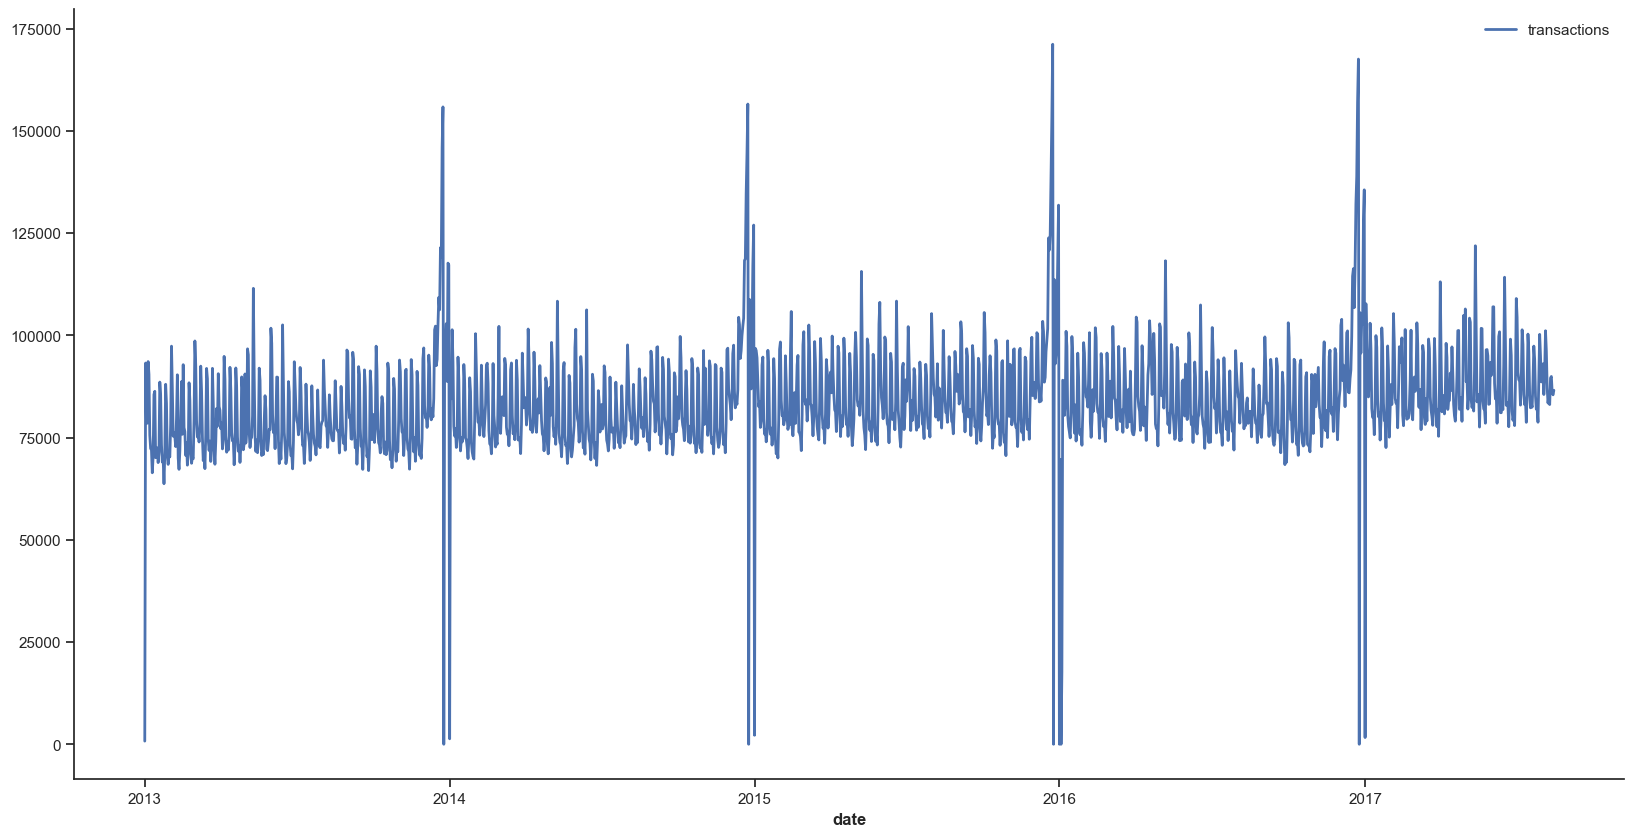

<Figure size 900x600 with 0 Axes>

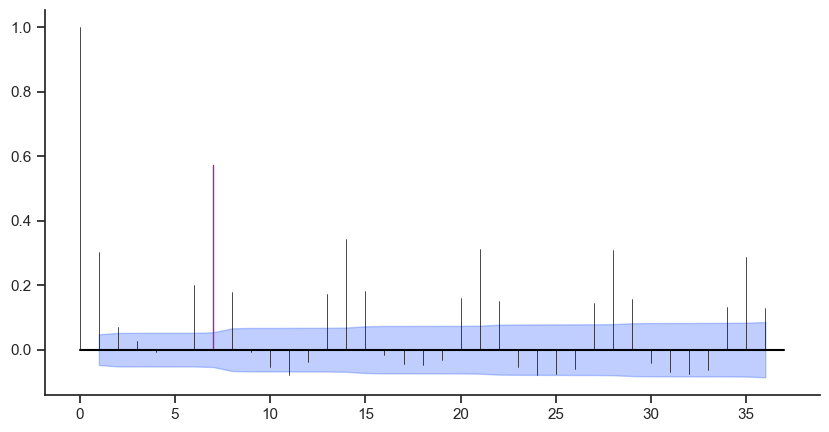

In [44]:
transactions_by_date = df_transactions.groupby('date')['transactions'].sum().reset_index()
transactions_by_date = transactions_by_date.sort_values('date')

transactions_by_date['date'] = pd.to_datetime(transactions_by_date['date'])

transactions_by_date['year'] = transactions_by_date['date'].dt.year

TS_transactions = darts.TimeSeries.from_dataframe(transactions_by_date, value_cols='transactions', time_col='date', fill_missing_dates=True, freq='D', fillna_value=0)

plt.figure(figsize=(20, 10))
TS_transactions.plot()

print(check_seasonality(TS_transactions, max_lag=36))

plt.figure(figsize=(9, 6))
plot_acf(TS_transactions, m=7, max_lag=36)





<Axes: xlabel='date'>

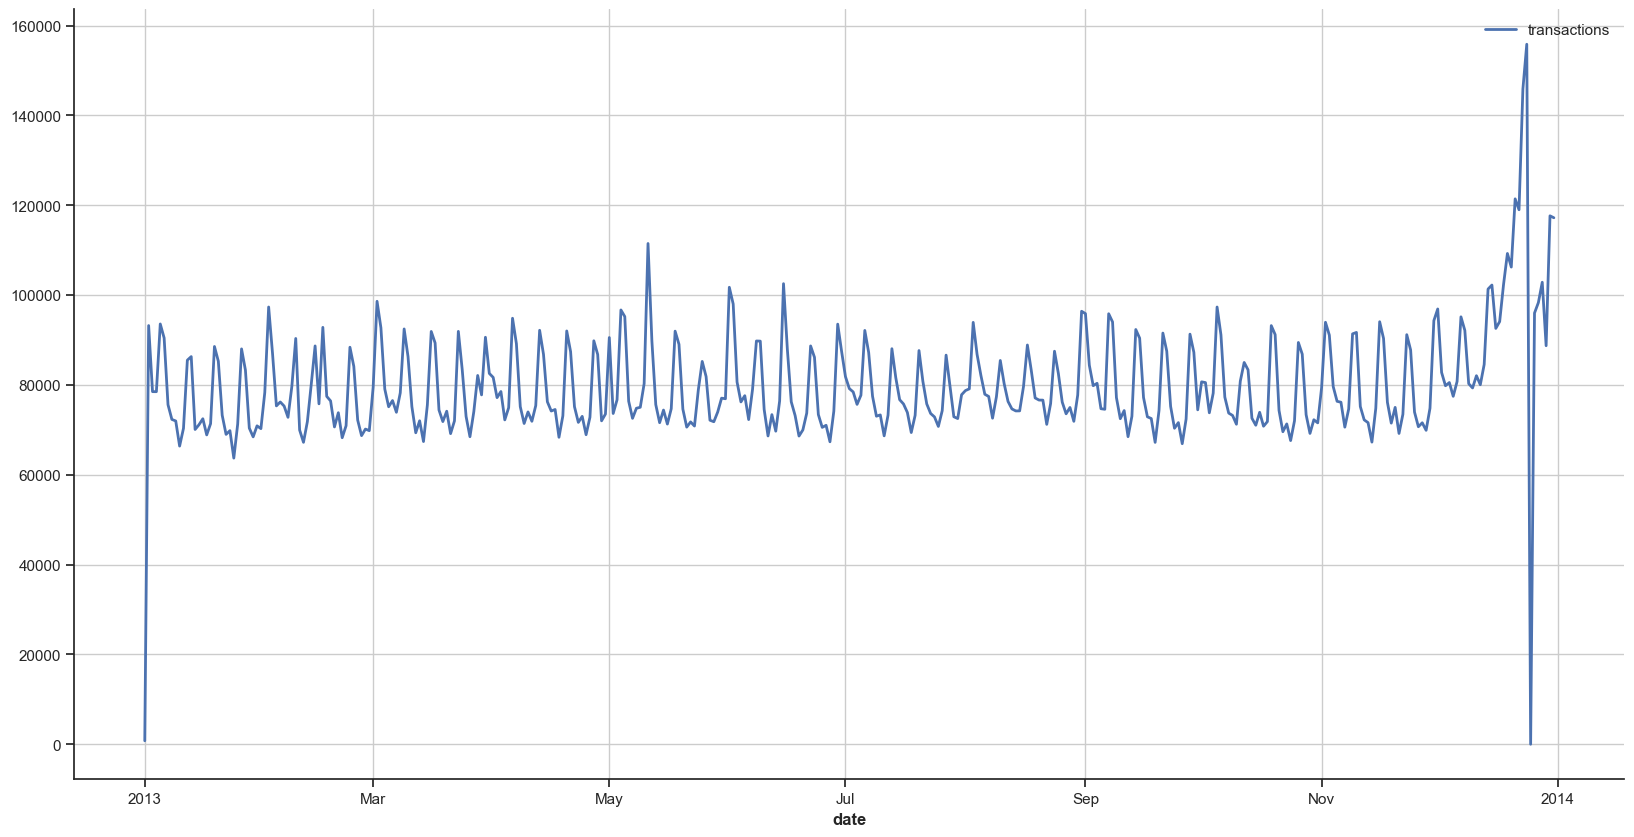

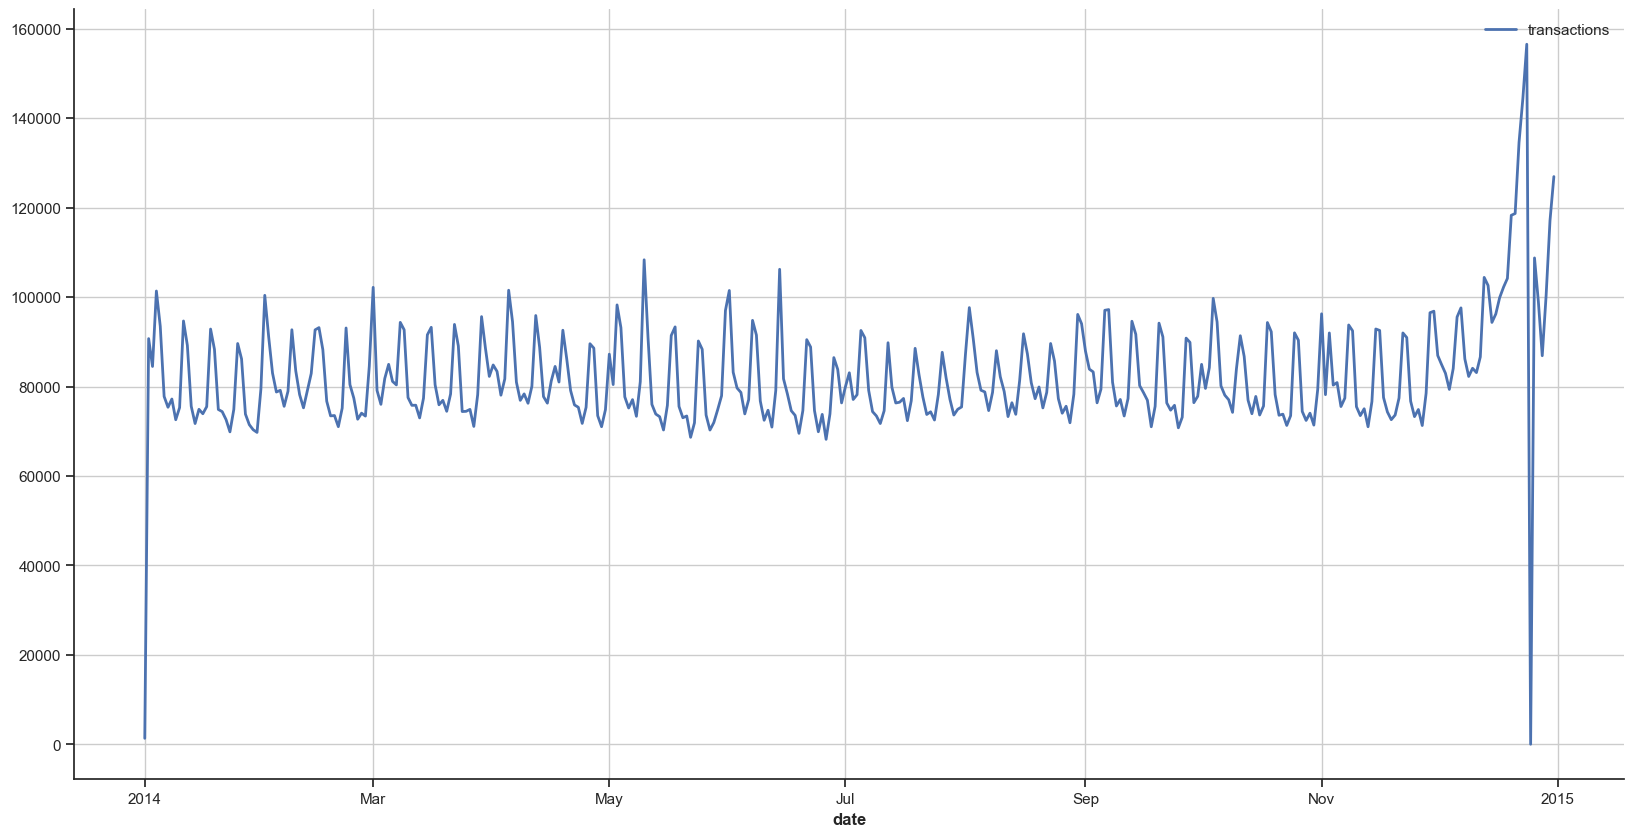

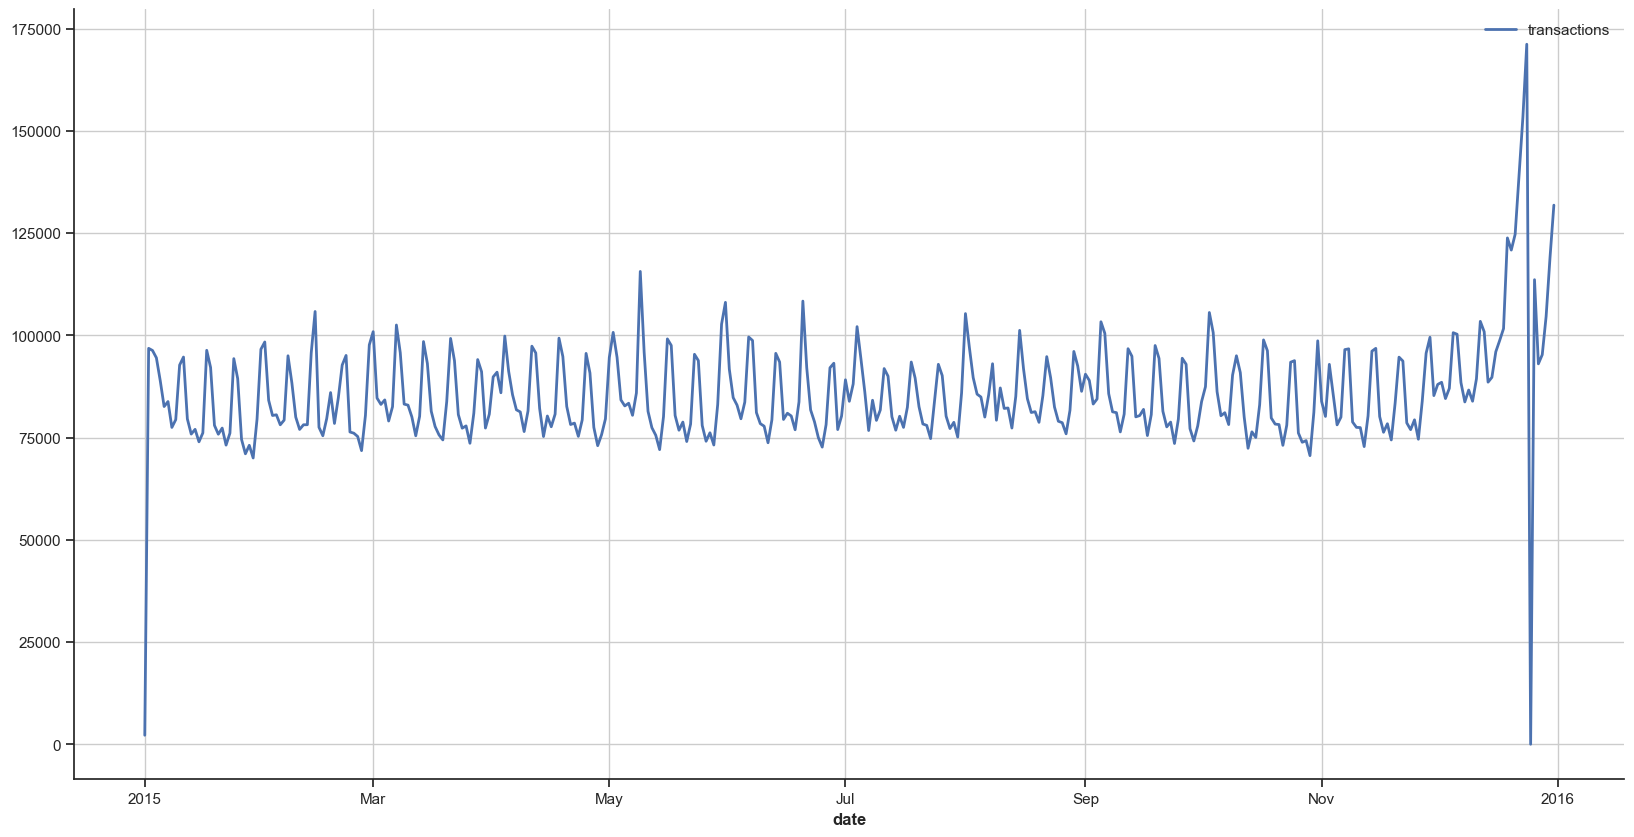

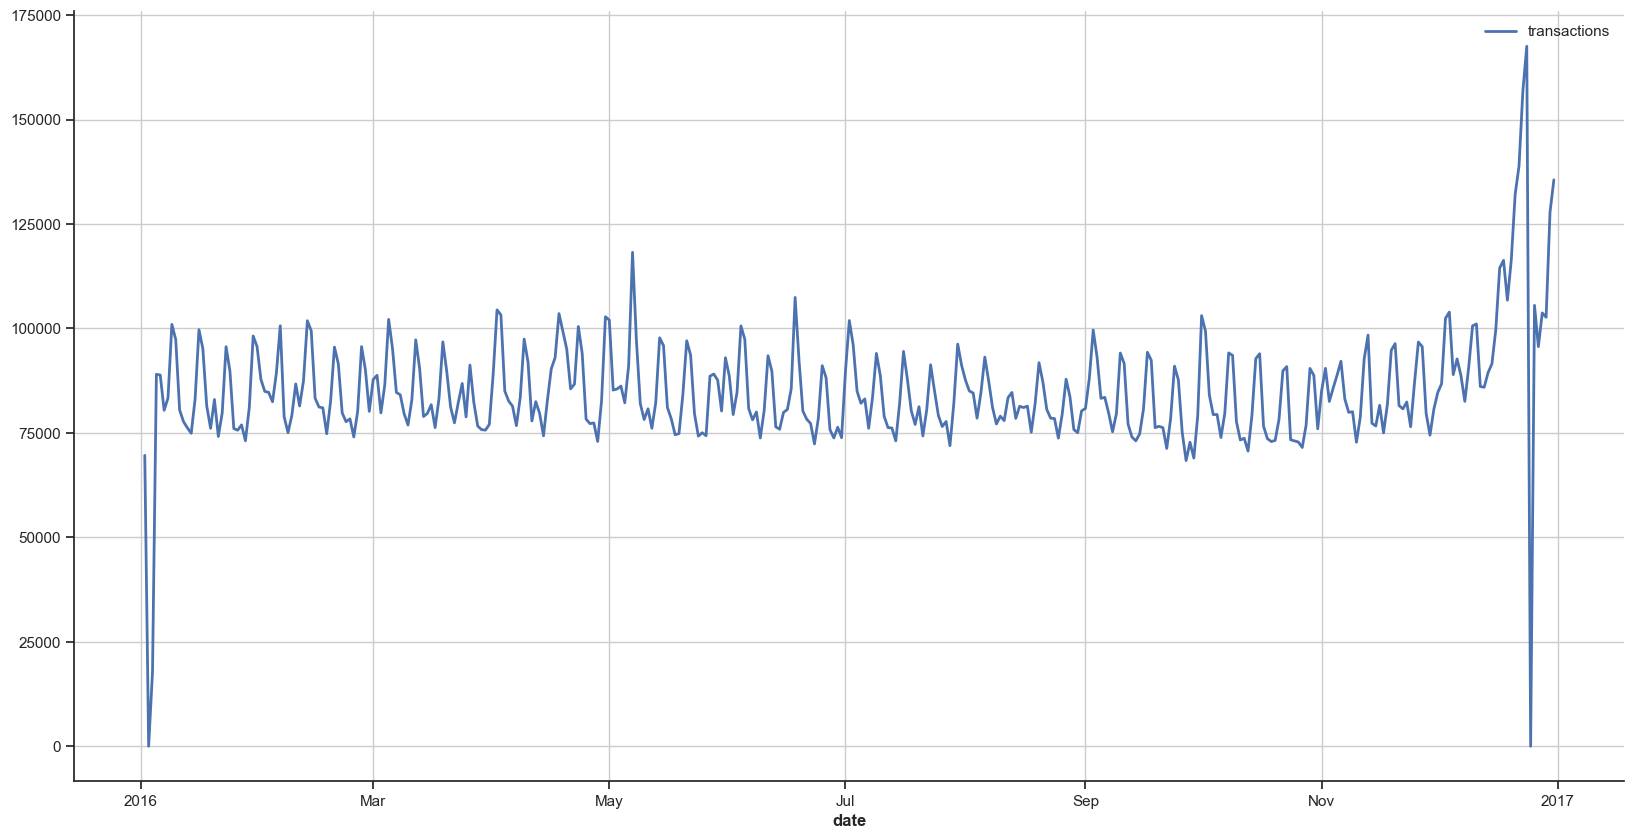

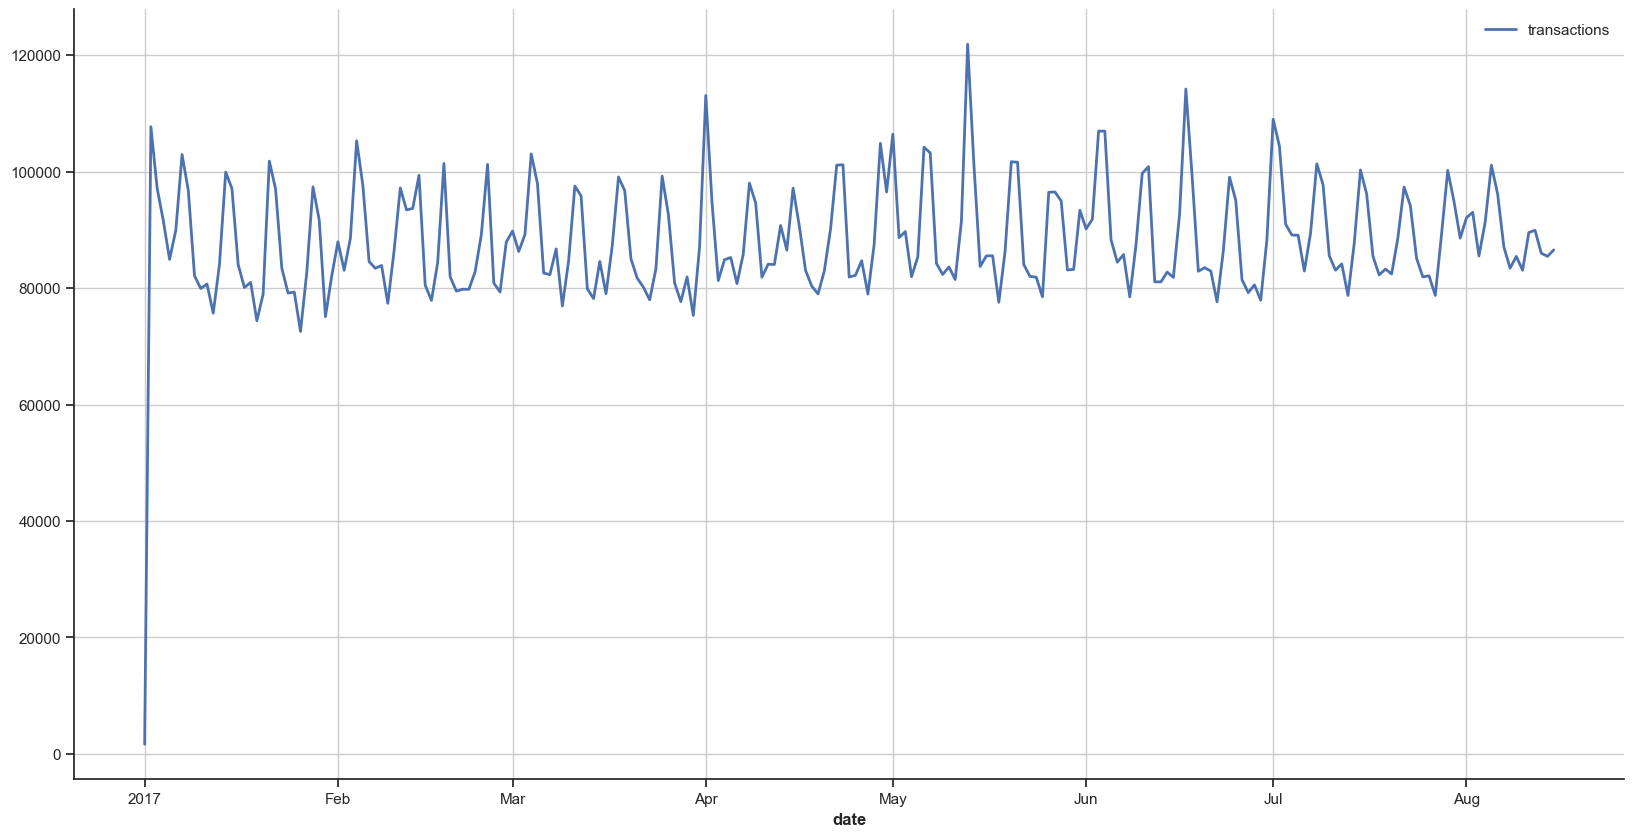

In [46]:
dfs_by_year = {
    year: group.drop(columns='year').reset_index(drop=True)
    for year, group in transactions_by_date.groupby('year')
}

df_2013 = dfs_by_year[2013]
df_2014 = dfs_by_year[2014]
df_2015 = dfs_by_year[2015]
df_2016 = dfs_by_year[2016]
df_2017 = dfs_by_year[2017]


TS_transactions_2013 = darts.TimeSeries.from_dataframe(df_2013, value_cols='transactions', time_col='date', fill_missing_dates=True, freq='D', fillna_value=0)

TS_transactions_2014 = darts.TimeSeries.from_dataframe(df_2014, value_cols='transactions', time_col='date', fill_missing_dates=True, freq='D', fillna_value=0)

TS_transactions_2015 = darts.TimeSeries.from_dataframe(df_2015, value_cols='transactions', time_col='date', fill_missing_dates=True, freq='D', fillna_value=0)

TS_transactions_2016 = darts.TimeSeries.from_dataframe(df_2016, value_cols='transactions', time_col='date', fill_missing_dates=True, freq='D', fillna_value=0)

TS_transactions_2017 = darts.TimeSeries.from_dataframe(df_2017, value_cols='transactions', time_col='date', fill_missing_dates=True, freq='D', fillna_value=0)

plt.figure(figsize=(20, 10))
plt.grid(True)
TS_transactions_2013.plot()


plt.figure(figsize=(20, 10))
plt.grid(True)
TS_transactions_2014.plot()

plt.figure(figsize=(20, 10))
plt.grid(True)
TS_transactions_2015.plot()

plt.figure(figsize=(20, 10))
plt.grid(True)
TS_transactions_2016.plot()

plt.figure(figsize=(20, 10))
plt.grid(True)
TS_transactions_2017.plot()



Podemos verificar uma sazonalidade anual, onde temos um pico de vendas proximo do inicio de cada mês e principalmente no final de Dezembro.

Podemos incluir também uma sazonalidade de 7 dias que pode ser devido à epoca de pagamento dos funcionários públicos.

In [10]:
transactions_by_date = transactions_by_date.set_index('date')

transactions_by_date['dayofweek'] = transactions_by_date.index.dayofweek #Segunda = 0, Domingo = 6
transactions_by_date['quarter'] = transactions_by_date.index.quarter 
transactions_by_date['month'] = transactions_by_date.index.month
transactions_by_date['dayofyear'] = transactions_by_date.index.dayofyear 

transactions_by_date.tail()


,transactions,year,dayofweek,quarter,month,dayofyear
date,,,,,,
2017-08-11,89551,2017,4,3,8,223
2017-08-12,89927,2017,5,3,8,224
2017-08-13,85993,2017,6,3,8,225
2017-08-14,85448,2017,0,3,8,226
2017-08-15,86561,2017,1,3,8,227


<Axes: xlabel='dayofweek', ylabel='transactions'>

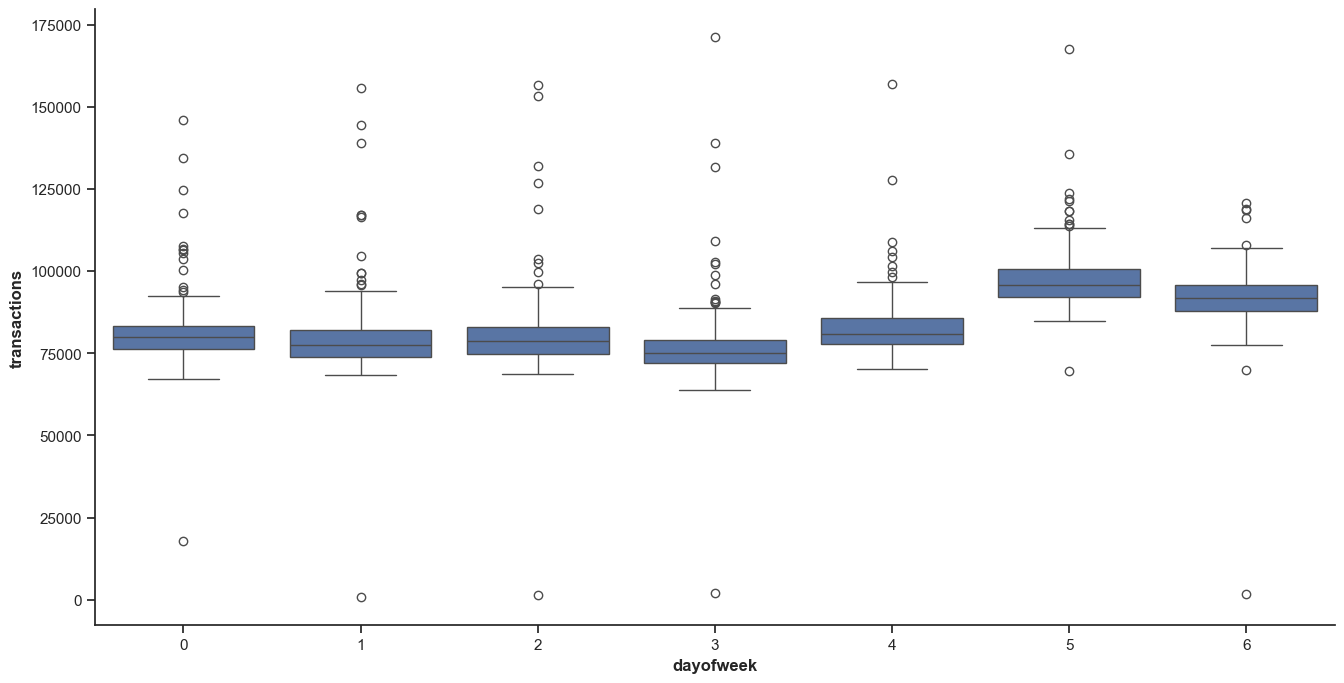

In [20]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=transactions_by_date, x='dayofweek', y='transactions')


<Axes: xlabel='month', ylabel='transactions'>

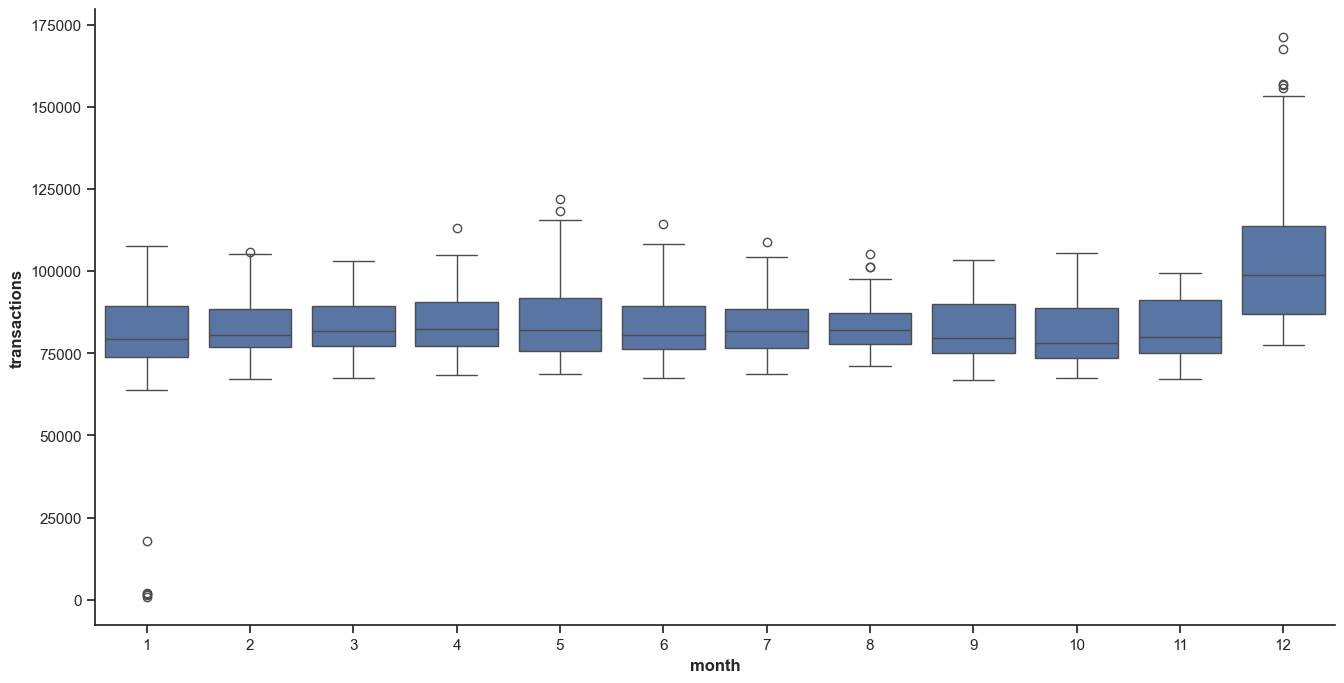

In [21]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=transactions_by_date, x='month', y='transactions')

<Axes: xlabel='year', ylabel='transactions'>

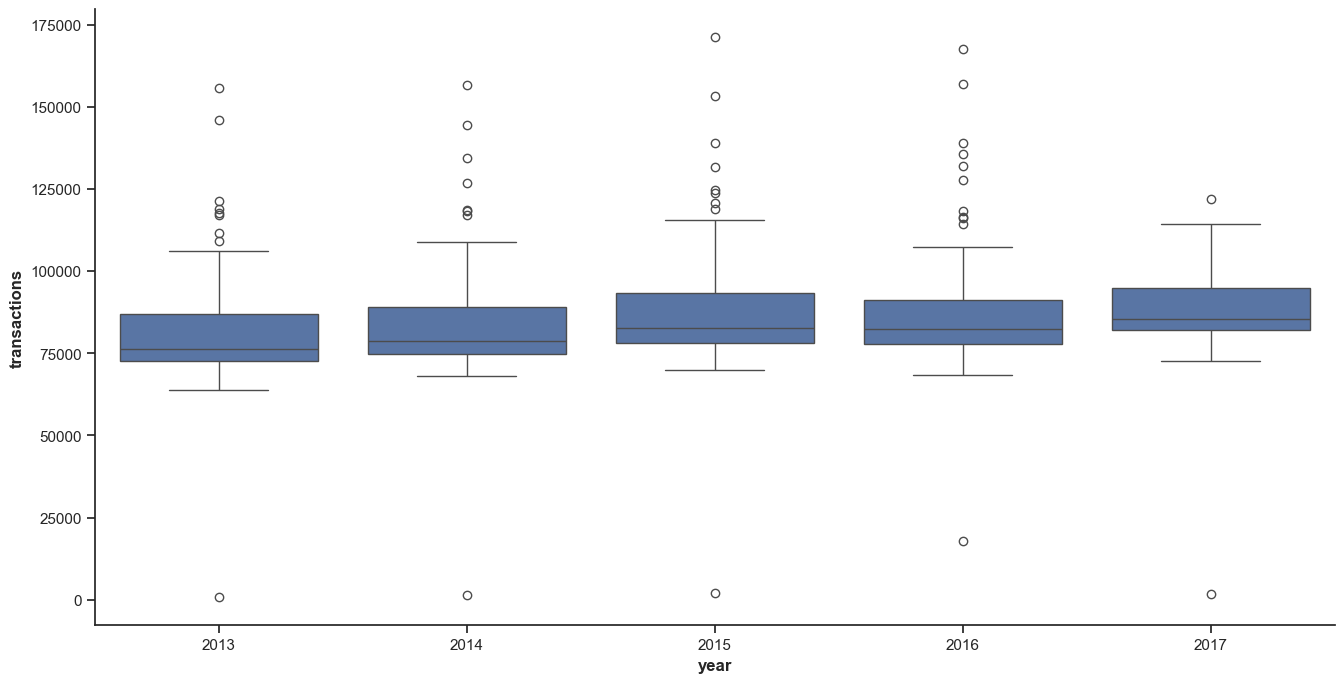

In [22]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=transactions_by_date, x='year', y='transactions')

# Criando o Modelo 1

Este é o primeiro modelo para a predição, onde estarei utilizando apenas o dataset de treino.

## Tratamento dos dados

In [49]:
df_train = train.copy()
df_test = test.copy()


df_train = df_train.drop('id', axis=1)
test_id = df_test['id']
df_test = df_test.drop('id', axis=1)

df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

In [ ]:
df_train = create_features(df_train)
#df_train.head()
df_test = create_features(df_test)
#df_test.head()

df_train = df_train.drop('date', axis=1)
df_test = df_test.drop('date', axis=1)

In [21]:
df_train.head()

,store_nbr,family,sales,onpromotion,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,1,AUTOMOTIVE,0.0,0,1,1,1,2013,1,1,1
1,1,BABY CARE,0.0,0,1,1,1,2013,1,1,1
2,1,BEAUTY,0.0,0,1,1,1,2013,1,1,1
3,1,BEVERAGES,0.0,0,1,1,1,2013,1,1,1
4,1,BOOKS,0.0,0,1,1,1,2013,1,1,1


In [22]:
df_train['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [23]:
X = df_train.drop('sales', axis=1)
y = df_train['sales']

In [26]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')

In [28]:
ohetransform = ohe.fit_transform(X[['family']])

In [30]:
X = pd.concat([X, ohetransform], axis=1).drop(columns=['family'])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Criando os modelos

### Usando BayesianRidge

In [77]:
reg_bayes = BayesianRidge()
reg_bayes.fit(X_train, y_train)

BayesianRidge()

In [79]:
y_pred_bayes = reg_bayes.predict(X_test)

for i in range(len(y_pred_bayes)):
    if y_pred_bayes[i] < 0:
        y_pred_bayes[i] = 0


In [81]:
rmsle_bayes= root_mean_squared_log_error(y_pred_bayes, y_test)

print(f'Erro: {rmsle_bayes}')

Erro: 2.3287528648194433


### Usando Regressão Linear

In [34]:
reg = LinearRegression().fit(X_train, y_train)

In [48]:
y_pred = reg.predict(X_test)

for i in range(len(y_pred)):
    if y_pred[i] < 0:
        y_pred[i] = 0 

In [50]:
rmsle = root_mean_squared_log_error(y_pred, y_test)

print(f'Erro: {rmsle}')

Erro: 2.3287211773049474


### Usando Random Forest Regression

In [51]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [52]:
y_pred_rfr = rfr.predict(X_test)

In [53]:
rmsle_rfr = root_mean_squared_log_error(y_pred, y_test)

In [55]:
print(f'Erro: {rmsle_rfr}')

Erro: 2.3287211773049474


### Usando XGBoost

In [89]:
reg_xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000, early_stopping_rounds=50, objective='reg:linear')

reg_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:896.91058	validation_1-rmse:913.16080
[100]	validation_0-rmse:299.72868	validation_1-rmse:331.73749
[200]	validation_0-rmse:260.37027	validation_1-rmse:302.31863
[300]	validation_0-rmse:239.21582	validation_1-rmse:288.39948
[400]	validation_0-rmse:224.41665	validation_1-rmse:284.54525
[444]	validation_0-rmse:220.01751	validation_1-rmse:282.01693


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [69]:
y_pred_xgb = reg_xgb.predict(X_test)

for i in range(len(y_pred_xgb)):
    if y_pred_xgb[i] < 0:
        y_pred_xgb[i] = 0



In [71]:
rmsle_xgb = root_mean_squared_log_error(y_pred_xgb, y_test)

print(f"Erro: {rmsle_xgb}")

Erro: 1.5289361878089083


A partir disso podemos ver que o Xgboost teve o melhor desempenho, e por conta disso utilizaremos ele para fazer a primeira submissão

## Fazendo a submissão

Primeiro vamos ajustar o `df_test`.

In [82]:
df_test.head()

,store_nbr,family,onpromotion,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,1,AUTOMOTIVE,0,2,3,8,2017,228,16,33
1,1,BABY CARE,0,2,3,8,2017,228,16,33
2,1,BEAUTY,2,2,3,8,2017,228,16,33
3,1,BEVERAGES,20,2,3,8,2017,228,16,33
4,1,BOOKS,0,2,3,8,2017,228,16,33


In [84]:
ohetransform_test = ohe.fit_transform(df_test[['family']])
ohetransform_test.head()

,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_test = pd.concat([df_test, ohetransform_test], axis=1).drop(columns=['family'])

In [87]:
df_test.head()

,store_nbr,onpromotion,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,family_AUTOMOTIVE,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,1,0,2,3,8,2017,228,16,33,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,2,3,8,2017,228,16,33,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2,2,3,8,2017,228,16,33,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,20,2,3,8,2017,228,16,33,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,2,3,8,2017,228,16,33,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
test_prediction_1 = reg_xgb.predict(df_test)

#caso tenhamos valores negativos:
for i in range(len(test_prediction_1)):
    if test_prediction_1[i] < 0:
        test_prediction_1[i] = 0

In [97]:
print(test_prediction_1)

[ 20.503595  15.868947  12.829767 ... 873.4846    71.41192    0.      ]


In [73]:
ids_sales_0 = find_ids_of_never_sold_items(never_sold_output, test)
print(ids_sales_0)

[3000889, 3000925, 3000958, 3000991, 3001021, 3001024, 3001057, 3001073, 3001090, 3001123, 3001138, 3001156, 3001189, 3001222, 3001288, 3001321, 3001354, 3001384, 3001468, 3001552, 3001567, 3001585, 3001600, 3001651, 3001667, 3001684, 3001717, 3001732, 3001750, 3001765, 3001783, 3001816, 3001831, 3001849, 3001948, 3002014, 3002029, 3002113, 3002128, 3002143, 3002176, 3002209, 3002242, 3002275, 3002308, 3002374, 3002407, 3002440, 3002443, 3002509, 3002524, 3002525, 3002641, 3002671, 3002707, 3002740, 3002773, 3002803, 3002806, 3002839, 3002855, 3002872, 3002905, 3002920, 3002938, 3002971, 3003004, 3003070, 3003103, 3003136, 3003166, 3003250, 3003334, 3003349, 3003367, 3003382, 3003433, 3003449, 3003466, 3003499, 3003514, 3003532, 3003547, 3003565, 3003598, 3003613, 3003631, 3003730, 3003796, 3003811, 3003895, 3003910, 3003925, 3003958, 3003991, 3004024, 3004057, 3004090, 3004156, 3004189, 3004222, 3004225, 3004291, 3004306, 3004307, 3004423, 3004453, 3004489, 3004522, 3004555, 3004585, 

In [102]:
submission = pd.DataFrame({
    'id': test_id,
    'sales': test_prediction_1
})

In [103]:
submission.head()

,id,sales
0,3000888,20.503595
1,3000889,15.868947
2,3000890,12.829767
3,3000891,2279.852783
4,3000892,15.968257


In [107]:
submission.tail(30)

,id,sales
28482,3029370,2883.568848
28483,3029371,0.000000
28484,3029372,469.193085
28485,3029373,0.000000
28486,3029374,1246.444702
28487,3029375,527.111938
28488,3029376,524.238708
28489,3029377,117.608437
28490,3029378,28.067507
28491,3029379,5717.146484


In [109]:
mod_submission = submission.copy()

mod_submission.loc[mod_submission['id'].isin(ids_sales_0), 'sales'] = 0

mod_submission.to_csv('submission_1.csv', index=False)

### Resultado no Kaggle

Consegui o Public Score de 1.38155, conforme a imagem abaixo.

![alt text](sub1.png)

# Criando o Modelo 2

Para esse modelo estarei utilizando a informação de feriados do arquivo `holidays_events.csv` e das lojas do arquivo `stores.csv`, além do que foi utilizado no modelo anterior.

## Tratamento dos Dados

### Adicionando os dados dos arquivos `holidays_events.csv` `stores.csv`

In [11]:
train['date'] = pd.to_datetime(train['date'])
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
test['date'] = pd.to_datetime(test['date'])

In [8]:
summary(df_holidays)

,type,count,nunique,%unique,null,%null,min,max
date,datetime64[ns],350,312,89.142857,0,0.0,2012-03-02 00:00:00,2017-12-26 00:00:00
type,object,350,6,1.714286,0,0.0,Additional,Work Day
locale,object,350,3,0.857143,0,0.0,Local,Regional
locale_name,object,350,24,6.857143,0,0.0,Ambato,Santo Domingo de los Tsachilas
description,object,350,103,29.428571,0,0.0,Batalla de Pichincha,Viernes Santo
transferred,bool,350,2,0.571429,0,0.0,False,True


In [9]:
summary(df_stores)

,type,count,nunique,%unique,null,%null,min,max
store_nbr,int64,54,54,100.000000,0,0.0,1,54
city,object,54,22,40.740741,0,0.0,Ambato,Santo Domingo
state,object,54,16,29.629630,0,0.0,Azuay,Tungurahua
type,object,54,5,9.259259,0,0.0,A,E
cluster,int64,54,17,31.481481,0,0.0,1,17


In [12]:
df_train1 = train.copy()
df_test1 = test.copy()

df_train1 = df_train1.merge(df_stores, on='store_nbr', how='left')
df_test1 = df_test1.merge(df_stores, on='store_nbr', how='left')


In [13]:
df_holidays1 = df_holidays[df_holidays['transferred'] == False].reset_index(drop=True)

com o `df_holidays1`, eu garanto que terei apenas as datas que ocorreram de fato o feriado.

In [14]:
feriados_list = ['Holiday', 'Transfer', 'Additional', 'Bridge']

feriados = df_holidays1[df_holidays1['type'].isin(feriados_list)][['date', 'type', 'locale', 'locale_name', 'description']]

eventos = df_holidays1[df_holidays1['type'] == 'Event'][['date']]

feriados_city = feriados[feriados['locale'] == 'Local'][['date', 'locale_name']]
feriados_state = feriados[feriados['locale'] == 'Regional'][['date', 'locale_name']]
feriados_country = feriados[feriados['locale'] == 'National'][['date']]


Aqui eu separei feriados de eventos, pois notei no csv que os datas do tipo `Event` estão relacionadas à datas de consumo, como Black Friday, ou datas onde ocorreram terremotos, que segundo a explicação do problema aumentava a venda de certos produtos como água e itens de primeiros socorros.

In [15]:
df_train1['is_holiday'] = (
       df_train1.merge(feriados_city, left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')['locale_name'].notnull() |
       df_train1.merge(feriados_state, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left')['locale_name'].notnull()
   )

In [16]:
df_train1['is_holiday'] = df_train1['is_holiday'] | df_train1['date'].isin(feriados_country['date'])

In [17]:
df_train1['is_event'] = df_train1['date'].isin(eventos['date'])

In [24]:
summary(df_train1)

,type,count,nunique,%unique,null,%null,min,max
id,int64,3000888,3000888,100.000000,0,0.0,0,3000887
date,datetime64[ns],3000888,1684,0.056117,0,0.0,2013-01-01 00:00:00,2017-08-15 00:00:00
store_nbr,int64,3000888,54,0.001799,0,0.0,1,54
family,object,3000888,33,0.001100,0,0.0,AUTOMOTIVE,SEAFOOD
sales,float64,3000888,379610,12.649922,0,0.0,0.0,124717.0
onpromotion,int64,3000888,362,0.012063,0,0.0,0,741
city,object,3000888,22,0.000733,0,0.0,Ambato,Santo Domingo
state,object,3000888,16,0.000533,0,0.0,Azuay,Tungurahua
type,object,3000888,5,0.000167,0,0.0,A,E
cluster,int64,3000888,17,0.000566,0,0.0,1,17


In [18]:
df_test1['is_holiday'] = (
       df_test1.merge(feriados_city, left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')['locale_name'].notnull() |
       df_test1.merge(feriados_state, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left')['locale_name'].notnull()
   )

In [19]:
df_test1['is_holiday'] = df_test1['is_holiday'] | df_test1['date'].isin(feriados_country['date'])

In [20]:
df_test1['is_event'] = df_test1['date'].isin(eventos['date'])

In [26]:
summary(df_test1)

,type,count,nunique,%unique,null,%null,min,max
id,int64,28512,28512,100.000000,0,0.0,3000888,3029399
date,datetime64[ns],28512,16,0.056117,0,0.0,2017-08-16 00:00:00,2017-08-31 00:00:00
store_nbr,int64,28512,54,0.189394,0,0.0,1,54
family,object,28512,33,0.115741,0,0.0,AUTOMOTIVE,SEAFOOD
onpromotion,int64,28512,212,0.743547,0,0.0,0,646
city,object,28512,22,0.077160,0,0.0,Ambato,Santo Domingo
state,object,28512,16,0.056117,0,0.0,Azuay,Tungurahua
type,object,28512,5,0.017536,0,0.0,A,E
cluster,int64,28512,17,0.059624,0,0.0,1,17
is_holiday,bool,28512,2,0.007015,0,0.0,False,True


### Transformando os dados categóricos

In [21]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')

In [22]:
ohetransform = ohe.fit_transform(df_train1[['family']])

df_train1 = pd.concat([df_train1, ohetransform], axis=1).drop(columns=['family'])

In [23]:
ohetransform = ohe.fit_transform(df_test1[['family']])

df_test1 = pd.concat([df_test1, ohetransform], axis=1).drop(columns=['family'])

In [24]:
ohetransform = ohe.fit_transform(df_train1[['type']])

df_train1 = pd.concat([df_train1, ohetransform], axis=1).drop(columns=['type'])


In [25]:
ohetransform = ohe.fit_transform(df_test1[['type']])

df_test1 = pd.concat([df_test1, ohetransform], axis=1).drop(columns=['type'])

### Criando a divisão de dados

In [45]:
X = df_train1.drop(columns=['id', 'sales', 'city', 'state'])
y = df_train1['sales']

In [57]:
X = create_features(X)
X = X.drop(columns=['date'])

In [55]:
test1_id = df_test1['id']

df_test1 = df_test1.drop(columns=['id', 'city', 'state'])

In [58]:
df_test1 = create_features(df_test1)

df_test1 = df_test1.drop(columns=['date'])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Criando o modelo

Vou estar utilizando apenas o XGBoost.

In [64]:
reg_xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000, early_stopping_rounds=50, objective='reg:linear')

reg_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:891.03423	validation_1-rmse:905.86497
[100]	validation_0-rmse:284.62245	validation_1-rmse:319.69982
[200]	validation_0-rmse:251.19348	validation_1-rmse:292.64295
[300]	validation_0-rmse:231.21731	validation_1-rmse:280.59577
[400]	validation_0-rmse:217.64521	validation_1-rmse:271.67628
[500]	validation_0-rmse:206.14851	validation_1-rmse:266.68875
[600]	validation_0-rmse:197.78250	validation_1-rmse:262.52693
[700]	validation_0-rmse:189.24003	validation_1-rmse:259.02287
[800]	validation_0-rmse:183.35467	validation_1-rmse:256.86220
[900]	validation_0-rmse:178.60797	validation_1-rmse:255.14894
[999]	validation_0-rmse:174.61035	validation_1-rmse:253.62604


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [69]:
y_pred = reg_xgb.predict(X_test)

for i in range(len(y_pred)):
    if y_pred[i] < 0:
        y_pred[i] = 0

In [70]:
rmsle_xgb = root_mean_squared_log_error(y_pred, y_test)

print(f"Erro: {rmsle_xgb}")

Erro: 1.4146309574848481


Podemos ver uma melhora de cerca de ~0.1

## Preparando a submissão 2

In [72]:
test_prediction_2 = reg_xgb.predict(df_test1)

#caso tenhamos valores negativos:
for i in range(len(test_prediction_2)):
    if test_prediction_2[i] < 0:
        test_prediction_2[i] = 0

In [74]:
submission_1 = pd.DataFrame({
    'id': test1_id,
    'sales': test_prediction_2
})

In [77]:
mod_submission_1 = submission_1.copy()

mod_submission_1.loc[mod_submission_1['id'].isin(ids_sales_0), 'sales'] = 0

mod_submission_1.to_csv('submission_2.csv', index=False)

## Resultado no Kaggle

Consegui o Public Score de 1.21819, conforme a imagem abaixo.

![alt text](sub2.png)

# Criando o Modelo 3

Esse será o modelo final, onde irei incluir os dados do valor diário do barril de petróleo do arquivo `oil.csv` e também irei adicionar a informação das dadas de pagamento de salário dos funcionários públicos.

## Análise das datas de pagamentos com o número de transações

In [14]:
transactions_by_date['day'] = transactions_by_date.index.day

<Axes: xlabel='day', ylabel='transactions'>

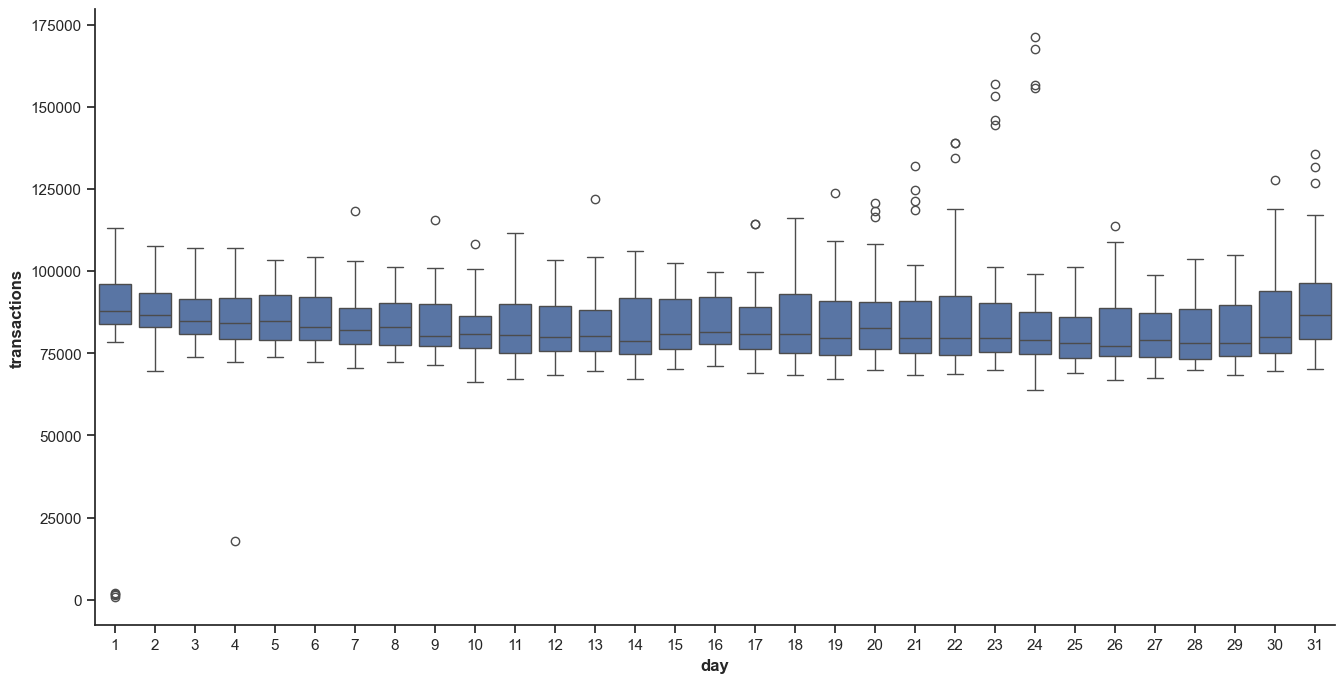

In [16]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=transactions_by_date, x='day', y='transactions')

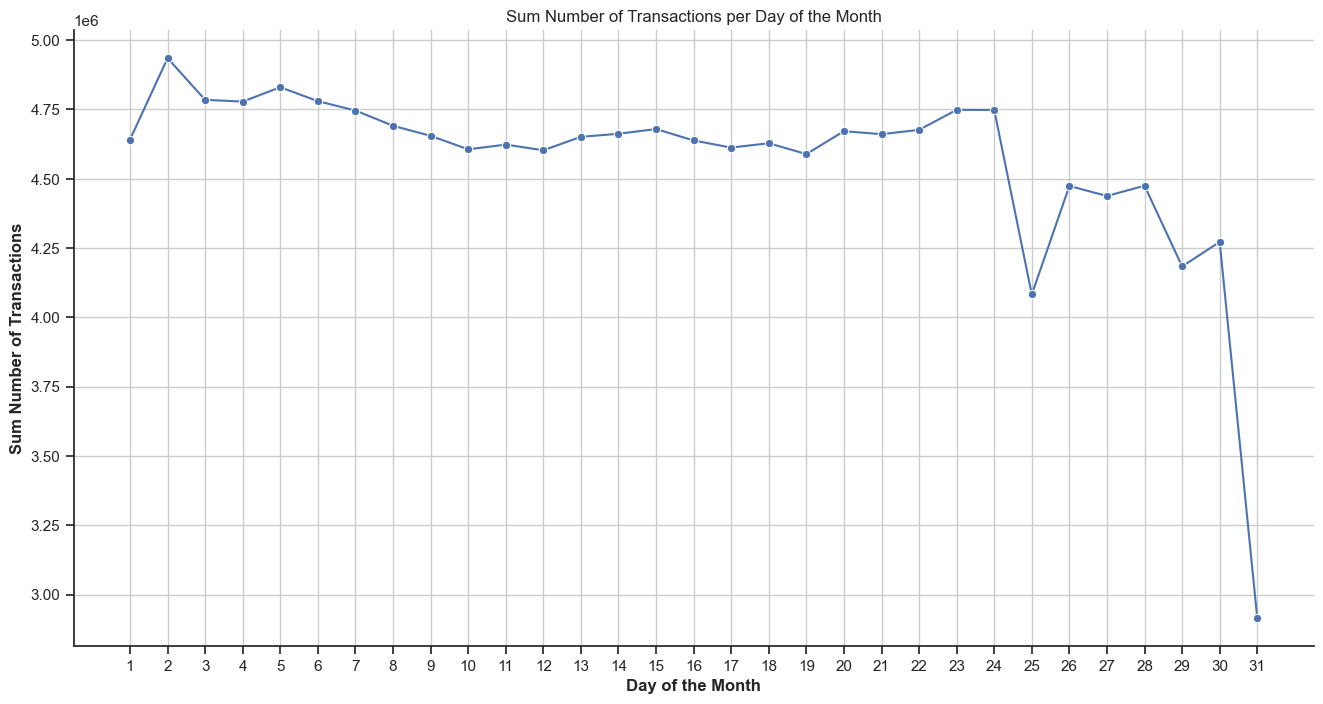

In [26]:
plt.figure(figsize=(16, 8))
sum_transactions_by_day = transactions_by_date.groupby('day')['transactions'].sum()
sns.lineplot(x=sum_transactions_by_day.index, y=sum_transactions_by_day.values, marker='o')
plt.xlabel('Day of the Month')
plt.ylabel('Sum Number of Transactions')
plt.title('Sum Number of Transactions per Day of the Month')
plt.xticks(range(1, 32))
plt.grid(True)
plt.show()

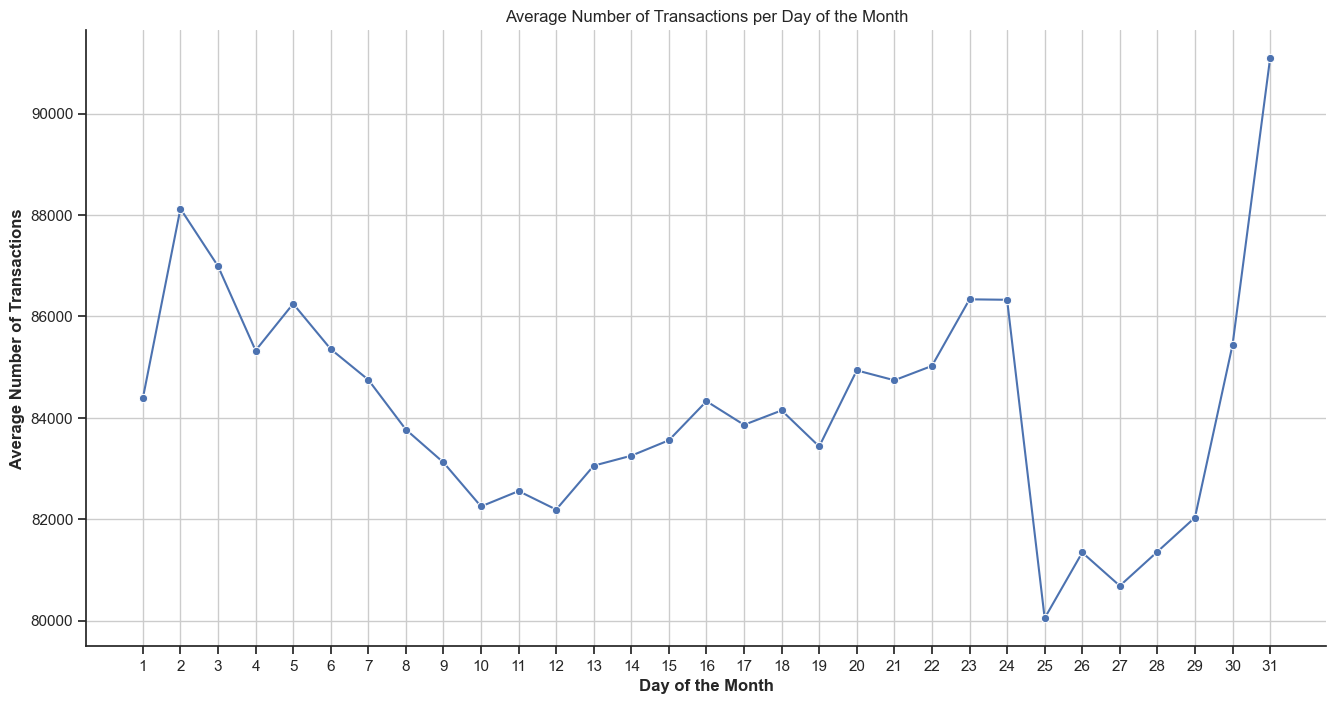

In [22]:
plt.figure(figsize=(16, 8))
avg_transactions_by_day = transactions_by_date.groupby('day')['transactions'].mean()
sns.lineplot(x=avg_transactions_by_day.index, y=avg_transactions_by_day.values, marker='o')
plt.xlabel('Day of the Month')
plt.ylabel('Average Number of Transactions')
plt.title('Average Number of Transactions per Day of the Month')
plt.xticks(range(1, 32))
plt.grid(True)
plt.show()

Podemos verificar que a média de transações aumenta consideravelmente após o dia 15 e 30 dos meses, o que condiz com a data de pagamento dos funcionarios públicos

In [26]:
df_train1 = create_features(df_train1)

summary(df_train1)

,type,count,nunique,%unique,null,%null,min,max
id,int64,3000888,3000888,100.000000,0,0.0,0,3000887
date,datetime64[ns],3000888,1684,0.056117,0,0.0,2013-01-01 00:00:00,2017-08-15 00:00:00
store_nbr,int64,3000888,54,0.001799,0,0.0,1,54
sales,float64,3000888,379610,12.649922,0,0.0,0.0,124717.0
onpromotion,int64,3000888,362,0.012063,0,0.0,0,741
city,object,3000888,22,0.000733,0,0.0,Ambato,Santo Domingo
state,object,3000888,16,0.000533,0,0.0,Azuay,Tungurahua
cluster,int64,3000888,17,0.000566,0,0.0,1,17
is_holiday,bool,3000888,2,0.000067,0,0.0,False,True
is_event,bool,3000888,2,0.000067,0,0.0,False,True


In [27]:
df_test1 = create_features(df_test1)

summary(df_test1)

,type,count,nunique,%unique,null,%null,min,max
id,int64,28512,28512,100.000000,0,0.0,3000888,3029399
date,datetime64[ns],28512,16,0.056117,0,0.0,2017-08-16 00:00:00,2017-08-31 00:00:00
store_nbr,int64,28512,54,0.189394,0,0.0,1,54
onpromotion,int64,28512,212,0.743547,0,0.0,0,646
city,object,28512,22,0.077160,0,0.0,Ambato,Santo Domingo
state,object,28512,16,0.056117,0,0.0,Azuay,Tungurahua
cluster,int64,28512,17,0.059624,0,0.0,1,17
is_holiday,bool,28512,2,0.007015,0,0.0,False,True
is_event,bool,28512,1,0.003507,0,0.0,False,False
family_AUTOMOTIVE,float64,28512,2,0.007015,0,0.0,0.0,1.0


In [28]:
df_train1['is_payday'] = df_train1['dayofmonth'].isin([15, 30])

summary(df_train1)

,type,count,nunique,%unique,null,%null,min,max
id,int64,3000888,3000888,100.000000,0,0.0,0,3000887
date,datetime64[ns],3000888,1684,0.056117,0,0.0,2013-01-01 00:00:00,2017-08-15 00:00:00
store_nbr,int64,3000888,54,0.001799,0,0.0,1,54
sales,float64,3000888,379610,12.649922,0,0.0,0.0,124717.0
onpromotion,int64,3000888,362,0.012063,0,0.0,0,741
city,object,3000888,22,0.000733,0,0.0,Ambato,Santo Domingo
state,object,3000888,16,0.000533,0,0.0,Azuay,Tungurahua
cluster,int64,3000888,17,0.000566,0,0.0,1,17
is_holiday,bool,3000888,2,0.000067,0,0.0,False,True
is_event,bool,3000888,2,0.000067,0,0.0,False,True


In [29]:
df_test1['is_payday'] = df_test1['dayofmonth'].isin([15, 30])


## Análise da influencia do preço do petróleo nas transações

In [30]:
df_oil['date'] = pd.to_datetime(df_oil['date'])

Podemos ver que no arquivo temos dados `NaN` e datas faltantes, para completar esses dados vou pegar o último valor do barril antes de ter o `NaN`  

In [31]:
full_dates = pd.date_range(df_oil['date'].min(), df_oil['date'].max(), freq='D')

df_oil = df_oil.set_index('date')
df_oil = df_oil.reindex(full_dates)
df_oil.index.name = 'date'

In [33]:
df_oil['dcoilwtico'].fillna(method='ffill', inplace=True)

In [37]:
df_oil.iloc[0, df_oil.columns.get_loc('dcoilwtico')] = 0

In [41]:
df_oil = df_oil.reset_index()

Agora o nosso dataframe `df_oil` esta completo e pronto para ser utilizado 

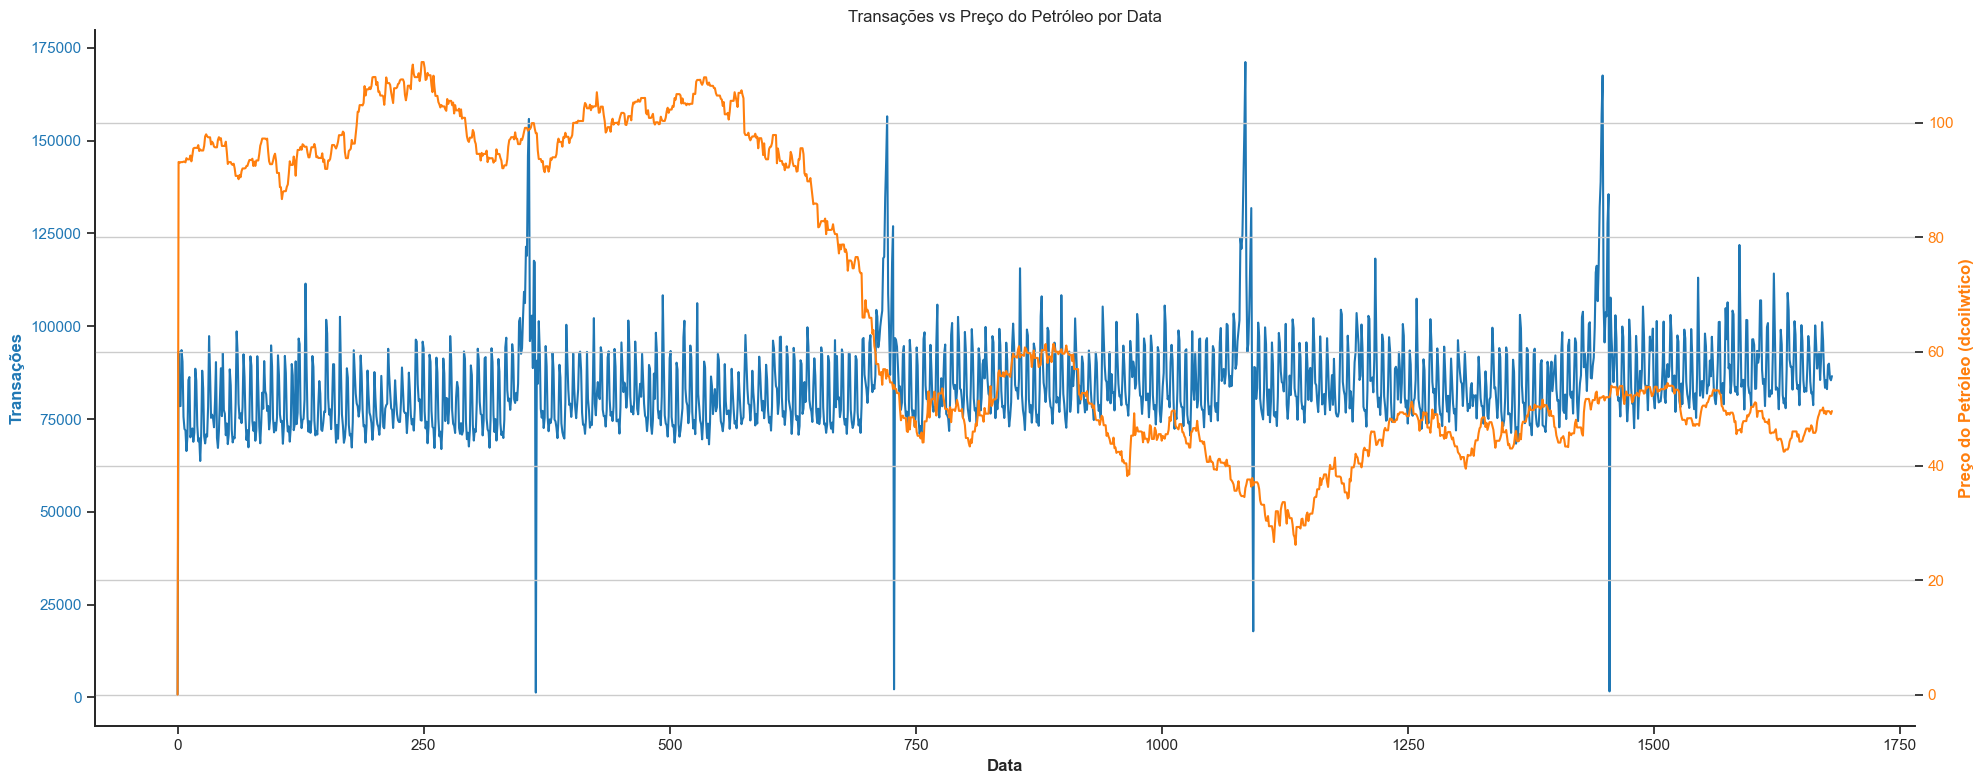

In [48]:
merged = transactions_by_date[['transactions']].join(df_oil[['dcoilwtico']], how='inner')

plt.figure(figsize=(20, 8))
ax1 = plt.gca()
color1 = 'tab:blue'
color2 = 'tab:orange'

ax1.set_xlabel('Data')
ax1.set_ylabel('Transações', color=color1)
ax1.plot(merged.index, merged['transactions'], color=color1, label='Transações')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
ax2.set_ylabel('Preço do Petróleo (dcoilwtico)', color=color2)
ax2.plot(merged.index, merged['dcoilwtico'], color=color2, label='Petróleo')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Transações vs Preço do Petróleo por Data')
plt.grid(True)
plt.tight_layout()
plt.show()

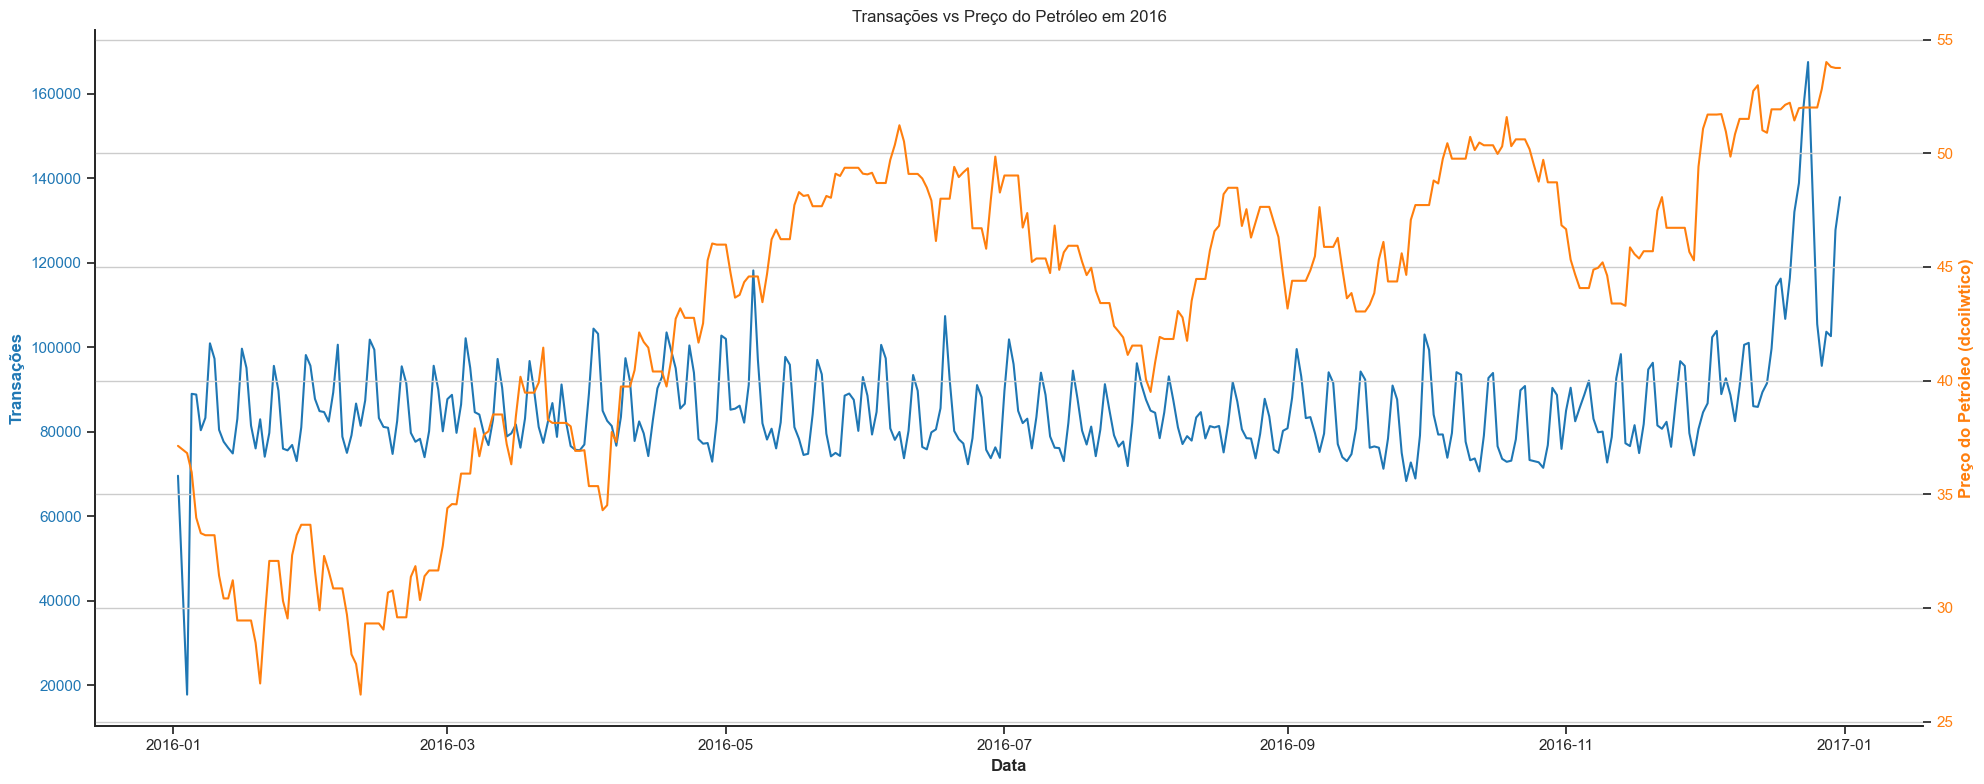

In [50]:
ano = 2016

start_date = f'{ano}-01-01'
end_date = f'{ano}-12-31'

transactions_by_date_ano = transactions_by_date.set_index('date').loc[start_date:end_date]
df_oil_ano = df_oil.set_index('date').loc[start_date:end_date]

merged = transactions_by_date_ano[['transactions']].join(df_oil_ano[['dcoilwtico']], how='inner')

plt.figure(figsize=(20, 8))
ax1 = plt.gca()
color1 = 'tab:blue'
color2 = 'tab:orange'

ax1.set_xlabel('Data')
ax1.set_ylabel('Transações', color=color1)
ax1.plot(merged.index, merged['transactions'], color=color1, label='Transações')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
ax2.set_ylabel('Preço do Petróleo (dcoilwtico)', color=color2)
ax2.plot(merged.index, merged['dcoilwtico'], color=color2, label='Petróleo')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title(f'Transações vs Preço do Petróleo em {ano}')
plt.grid(True)
plt.tight_layout()
plt.show()

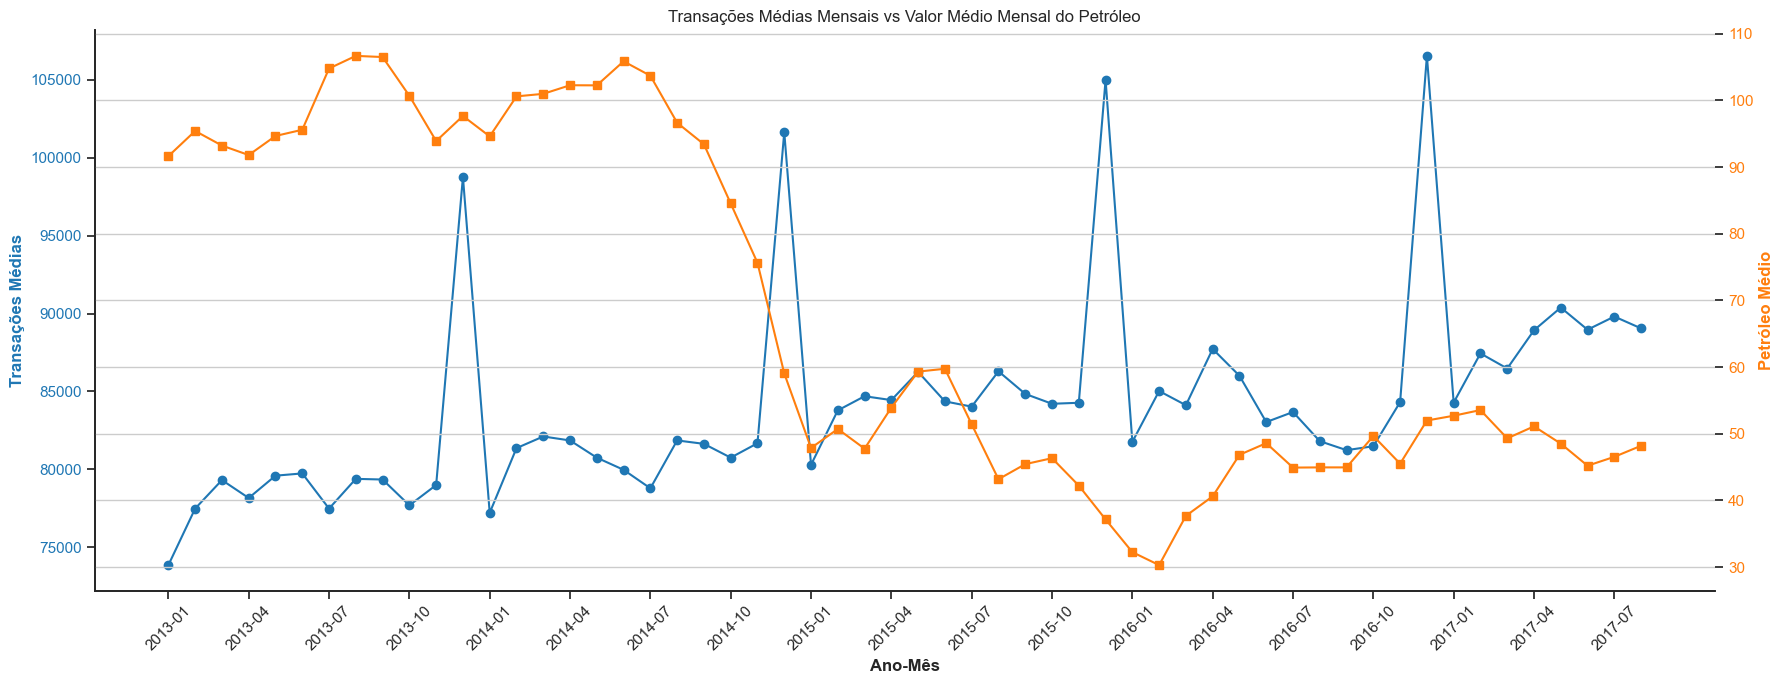

In [52]:
transacoes_mensais = transactions_by_date.groupby(transactions_by_date['date'].dt.to_period('M'))['transactions'].mean()
petroleo_mensal = df_oil.groupby(df_oil['date'].dt.to_period('M'))['dcoilwtico'].mean()

# Unir os resultados em um DataFrame
media_mensal = pd.DataFrame({
    'Transações Médias': transacoes_mensais,
    'Petróleo Médio': petroleo_mensal
})

# Plotar
fig, ax1 = plt.subplots(figsize=(18, 7))
color1 = 'tab:blue'
color2 = 'tab:orange'

ax1.set_xlabel('Ano-Mês')
ax1.set_ylabel('Transações Médias', color=color1)
ax1.plot(media_mensal.index.astype(str), media_mensal['Transações Médias'], color=color1, marker='o', label='Transações Médias')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(media_mensal.index.astype(str)[::3])  # Mostrar um mês a cada 3 para não poluir
ax1.set_xticklabels(media_mensal.index.astype(str)[::3], rotation=45)

ax2 = ax1.twinx()
ax2.set_ylabel('Petróleo Médio', color=color2)
ax2.plot(media_mensal.index.astype(str), media_mensal['Petróleo Médio'], color=color2, marker='s', label='Petróleo Médio')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Transações Médias Mensais vs Valor Médio Mensal do Petróleo')
plt.grid(True)
plt.tight_layout()
plt.show()

Com base nos gráficos é possível perceber que enquanto o valor médio do barril do petróleo diminuia, a quantidade de transações aumentava. 